In [ ]:
#from google.colab import files      # For uploading/downloading files in Google Colab
#print("Please upload your csv file")
#uploaded = files.upload()  # Opens a file upload dialog box in Google Colab

In [ ]:
# ============================================================
# SUPER SIMPLE TIME SERIES ANALYSIS
# Dataset: PublishingEmployees.csv
#
# What this script does:
#   1. Reads the publishing employees data
#   2. Builds a monthly time series of number of employees
#   3. Decomposes into: Trend, Seasonality, Noise + Cyclicality
#   4. Runs ADF tests for stationarity
#   5. Splits data into Train and Test (last 12 months as Test)
#   6. Fits a simple ARIMA model
#   7. Plots Actual vs Forecast
#   8. Makes extra forecasts for:
#         - Next 14 MONTHS
#         - Next QUARTER (next 3 months)
# ============================================================

# ============================================================


In [1]:
# ---- IMPORT LIBRARIES ----
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Helper to clean and rotate x-axis labels everywhere
def clean_xaxis(ax, angle=60):
    """
    Makes x-axis readable:
    - yearly ticks
    - rotated labels
    - right-aligned
    """
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.setp(ax.get_xticklabels(),
             rotation=angle,
             ha='right',
             fontsize=10)

In [3]:
# STEP 1: LOAD THE DATA
# ============================================================

# Read the CSV file
# Make sure "PublishingEmployees.csv" is in the same folder as your notebook.
data = pd.read_csv("PublishingEmployees.csv")

# The file has columns: "Date" and "Employees"
# Convert "Date" to a proper datetime object
data["Date"] = pd.to_datetime(data["Date"])

# Set "Date" as the index of the DataFrame (very common for time series)
data = data.set_index("Date")

# Just keep the Employees column as a time series
ts = data["Employees"]

# The dates are all first-of-month, so we enforce a monthly frequency
# "MS" = Month Start
ts = ts.asfreq("MS")

print("First few rows of the time series:")
print(ts.head())

First few rows of the time series:
Date
1990-01-01    69.1
1990-02-01    69.2
1990-03-01    69.9
1990-04-01    69.7
1990-05-01    69.8
Freq: MS, Name: Employees, dtype: float64


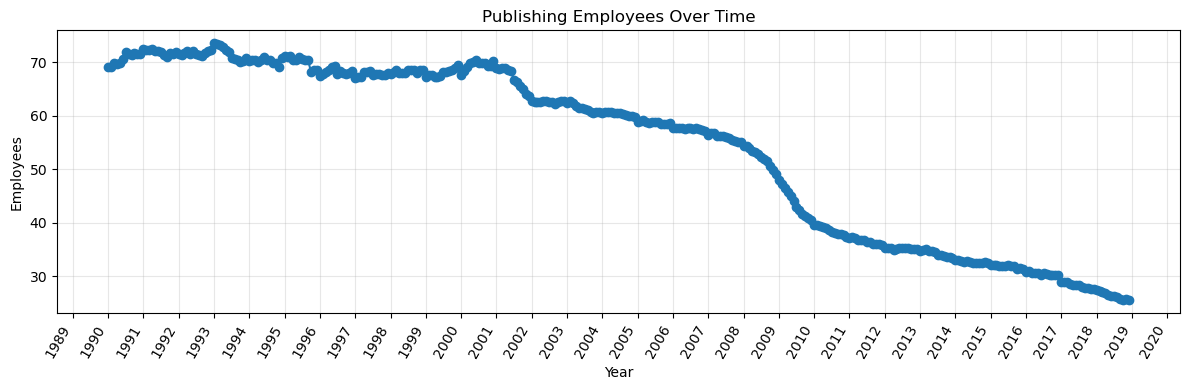

In [4]:
# ============================================================
# STEP 2: BASIC PLOT OF THE TIME SERIES
# ============================================================

plt.figure(figsize=(12, 4))
plt.plot(ts.index, ts, marker="o")
plt.title("Publishing Employees Over Time")
plt.xlabel("Year")
plt.ylabel("Employees")
plt.grid(True, alpha=0.3)

ax = plt.gca()
clean_xaxis(ax)  # 🔹 rotated labels

plt.tight_layout()
plt.show()


In [5]:
# ============================================================
# STEP 3: DECOMPOSE THE TIME SERIES
# Into: Trend, Seasonality, Residuals, plus Cyclicality
# ============================================================

# We know this is monthly data, so we assume yearly seasonality → period = 12 months
decomp = seasonal_decompose(ts, model="additive", period=12)

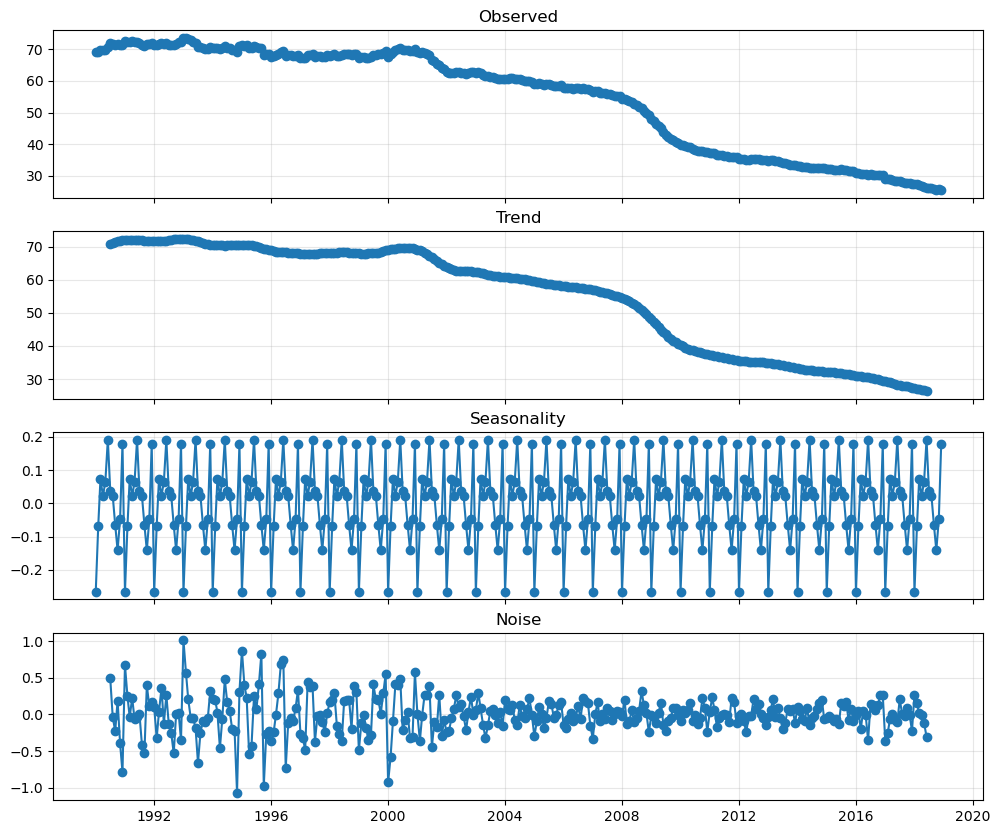

In [6]:
trend = decomp.trend        # long-term direction
seasonal = decomp.seasonal  # pattern that repeats each year
resid = decomp.resid        # what's left after removing trend + seasonality

# ---- CYCLICALITY ----
# Cycles = slower ups and downs not tied to a fixed fixed-length like "1 year".
# We approximate cycles by smoothing the residuals with a moving average.
cycle = resid.rolling(window=6, center=True, min_periods=3).mean()

# Whatever remains after removing this cycle from residuals we call "noise"
noise = resid - cycle

# ---- Plot the decomposition: Observed, Trend, Seasonality, Noise ----
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(ts.index, ts, marker="o")
axes[0].set_title("Observed")
axes[0].grid(True, alpha=0.3)

axes[1].plot(trend.index, trend, marker="o")
axes[1].set_title("Trend")
axes[1].grid(True, alpha=0.3)

axes[2].plot(seasonal.index, seasonal, marker="o")
axes[2].set_title("Seasonality")
axes[2].grid(True, alpha=0.3)

axes[3].plot(noise.index, noise, marker="o")
axes[3].set_title("Noise")
axes[3].grid(True, alpha=0.3)

<Figure size 640x480 with 0 Axes>

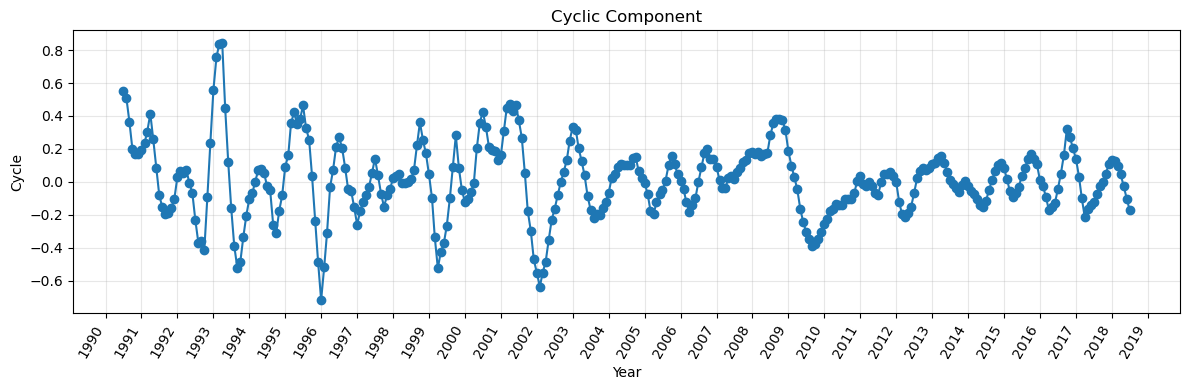

In [8]:

clean_xaxis(axes[3])  # 🔹 rotated labels for bottom axis

plt.tight_layout()
plt.show()

# ---- Plot Cyclicality separately ----
plt.figure(figsize=(12, 4))
plt.plot(cycle.index, cycle, marker="o")
plt.title("Cyclic Component")
plt.xlabel("Year")
plt.ylabel("Cycle")
plt.grid(True, alpha=0.3)

ax = plt.gca()
clean_xaxis(ax)  # 🔹 rotated labels

plt.tight_layout()
plt.show()

In [9]:

# ============================================================
# STEP 4: ADF (AUGMENTED DICKEY-FULLER) TEST FOR STATIONARITY
# ============================================================

def run_adf_test(series, title):
    """
    Runs the ADF test on a time series and prints an easy-to-understand summary.
    """
    print("\n" + "="*60)
    print(title)
    print("="*60)

    series = series.dropna()

    result = adfuller(series)

    adf_stat = result[0]
    p_value = result[1]
    used_lags = result[2]
    n_obs = result[3]
    critical_values = result[4]

    print(f"ADF Statistic : {adf_stat}")
    print(f"p-value       : {p_value}")
    print(f"# Lags Used   : {used_lags}")
    print(f"# Observations: {n_obs}")

    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"   {key}: {value}")

    if p_value <= 0.05:
        print("Conclusion: p-value <= 0.05 → reject H0 → series is LIKELY STATIONARY.")
    else:
        print("Conclusion: p-value > 0.05 → fail to reject H0 → series is LIKELY NON-STATIONARY.")


# ADF test on original series
run_adf_test(ts, "ADF Test on ORIGINAL Employees Series")


ADF Test on ORIGINAL Employees Series
ADF Statistic : 0.43973552745593353
p-value       : 0.9829216124662374
# Lags Used   : 14
# Observations: 333
Critical Values:
   1%: -3.450141065277327
   5%: -2.870258846235788
   10%: -2.571415151457764
Conclusion: p-value > 0.05 → fail to reject H0 → series is LIKELY NON-STATIONARY.


In [10]:
# ============================================================
# STEP 5: TRAIN / TEST SPLIT
# ============================================================
# We will use the last 12 months as TEST data
# Everything before that is TRAIN data.

test_size = 12  # months
train = ts.iloc[:-test_size]
test = ts.iloc[-test_size:]

print("\nTrain period:", train.index.min().date(), "to", train.index.max().date())
print("Test period :", test.index.min().date(), "to", test.index.max().date())
print("Train size:", len(train), " | Test size:", len(test))


Train period: 1990-01-01 to 2017-12-01
Test period : 2018-01-01 to 2018-12-01
Train size: 336  | Test size: 12


In [11]:
# ============================================================
# STEP 6: FIT A SIMPLE ARIMA MODEL
# ============================================================
# ARIMA(p, d, q)
# For simplicity in teaching, we choose ARIMA(1, 1, 1).
# In practice, we should tune p, d, q using AIC/BIC or auto_arima.

model_order = (1, 1, 1)

print(f"\nFitting ARIMA{model_order} model on TRAIN data...")

arima_model = ARIMA(train, order=model_order)
arima_result = arima_model.fit()

print("\nModel fitted. Short summary:")
print(arima_result.summary())


Fitting ARIMA(1, 1, 1) model on TRAIN data...


c:\Users\MuriloFarias\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\MuriloFarias\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Model fitted. Short summary:
                               SARIMAX Results                                
Dep. Variable:              Employees   No. Observations:                  336
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -201.582
Date:                Tue, 18 Nov 2025   AIC                            409.164
Time:                        17:45:14   BIC                            420.606
Sample:                    01-01-1990   HQIC                           413.725
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9752      0.028     34.699      0.000       0.920       1.030
ma.L1         -0.8985      0.048    -18.842      0.000      -0.992      -0.805
sigma2         0.1948 

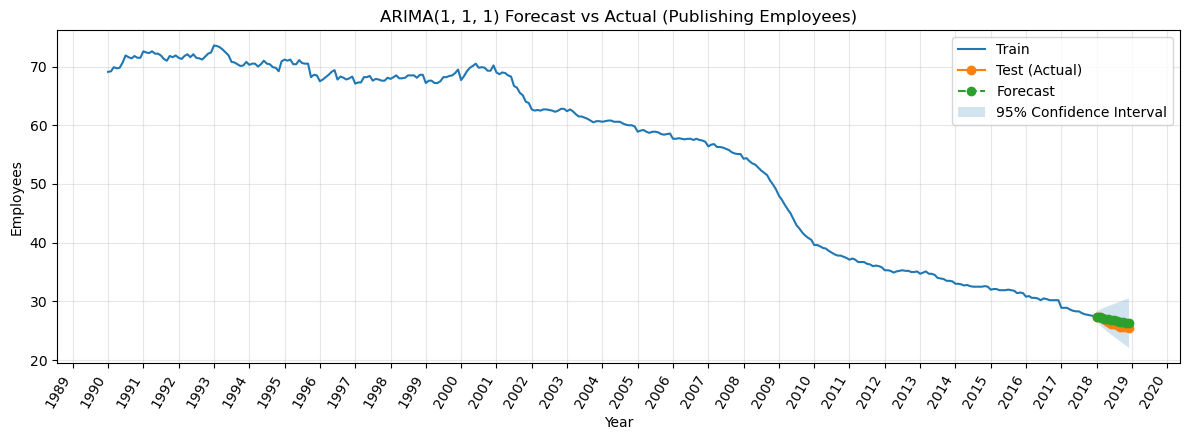


Forecast Accuracy on TEST set:
RMSE: 0.58
MAE : 0.49

(Compare these errors to typical employee levels to judge if it's 'big' or 'small').


In [12]:
# ============================================================
# STEP 7: FORECAST ON TEST PERIOD AND PLOT RESULTS
# ============================================================

# Number of forecast steps = length of test set (12 months)
n_test = len(test)

forecast_obj = arima_result.get_forecast(steps=n_test)
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

# Align forecast index with test index
forecast_mean.index = test.index
forecast_ci.index = test.index

# Plot Actual vs Forecast
plt.figure(figsize=(12, 4.5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, marker="o", label="Test (Actual)")
plt.plot(forecast_mean.index, forecast_mean, marker="o", linestyle="--",
         label="Forecast")

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title(f"ARIMA{model_order} Forecast vs Actual (Publishing Employees)")
plt.xlabel("Year")
plt.ylabel("Employees")
plt.legend()
plt.grid(True, alpha=0.3)

ax = plt.gca()
clean_xaxis(ax)  # rotated x-axis for ARIMA plot

plt.tight_layout()
plt.show()

# Forecast accuracy
rmse = sqrt(mean_squared_error(test, forecast_mean))
mae = mean_absolute_error(test, forecast_mean)

print("\nForecast Accuracy on TEST set:")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")
print("\n(Compare these errors to typical employee levels to judge if it's 'big' or 'small').")




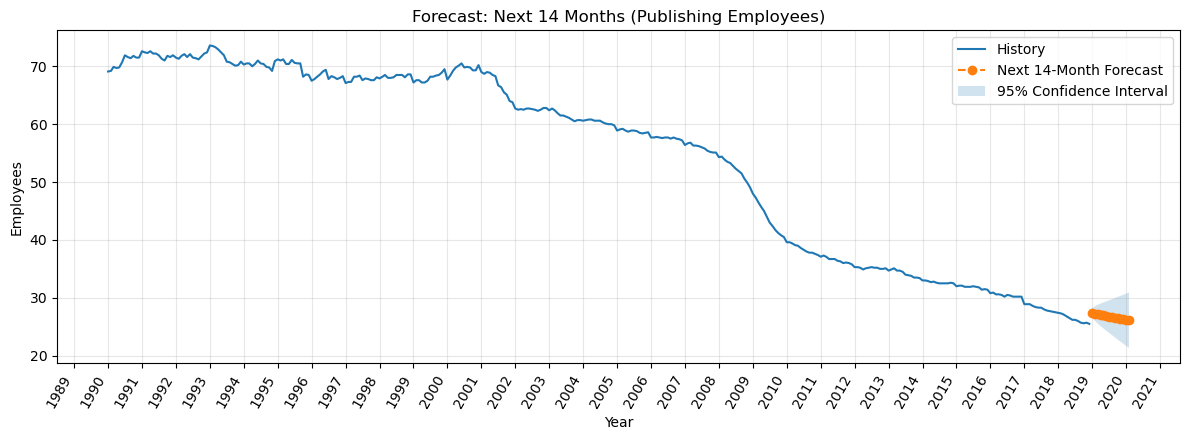


Next 14-Month Forecast (Employees):
2019-01-01    27.385767
2019-02-01    27.274364
2019-03-01    27.165719
2019-04-01    27.059764
2019-05-01    26.956433
2019-06-01    26.855661
2019-07-01    26.757384
2019-08-01    26.661540
2019-09-01    26.568071
2019-10-01    26.476915
2019-11-01    26.388017
2019-12-01    26.301321
2020-01-01    26.216771
2020-02-01    26.134315
Freq: MS, Name: predicted_mean, dtype: float64


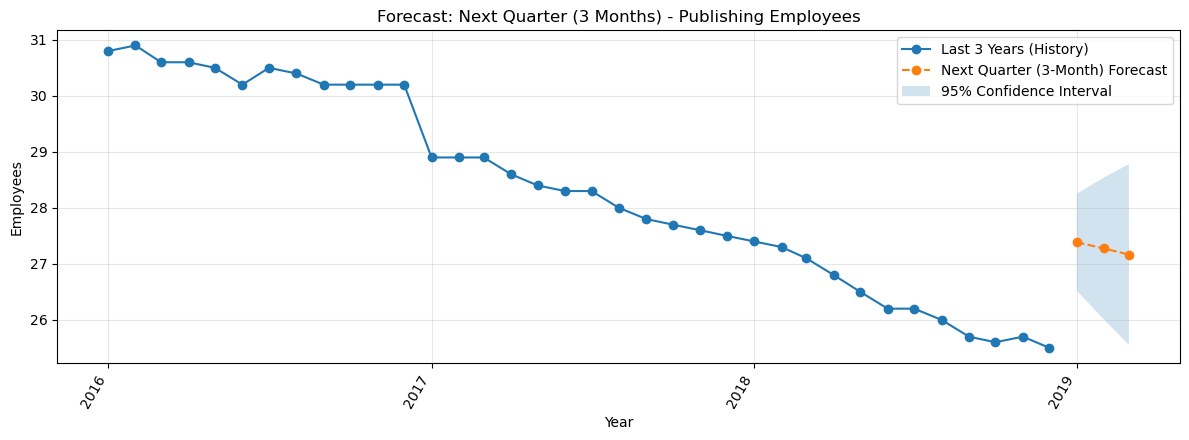


Next Quarter (3-Month) Forecast (Employees):
2019-01-01    27.385767
2019-02-01    27.274364
2019-03-01    27.165719
Freq: MS, Name: predicted_mean, dtype: float64


In [13]:
# ============================================================
# STEP 8: EXTRA FORECASTS
# - Next 14 MONTHS (since data is monthly)
# - Next QUARTER (3 months)
# ============================================================

# ---------- A. Next 14 MONTHS ----------
n_future_months = 14

future_forecast_obj = arima_result.get_forecast(steps=n_future_months)
future_mean = future_forecast_obj.predicted_mean
future_ci = future_forecast_obj.conf_int()

# Create future monthly index starting from the month after the last observation
future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.MonthBegin(),
    periods=n_future_months,
    freq="MS"   # Month Start
)

future_mean.index = future_index
future_ci.index = future_index

plt.figure(figsize=(12, 4.5))
plt.plot(ts.index, ts, label="History")
plt.plot(future_mean.index, future_mean, marker="o", linestyle="--",
         label="Next 14-Month Forecast")

plt.fill_between(
    future_ci.index,
    future_ci.iloc[:, 0],
    future_ci.iloc[:, 1],
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title("Forecast: Next 14 Months (Publishing Employees)")
plt.xlabel("Year")
plt.ylabel("Employees")
plt.legend()
plt.grid(True, alpha=0.3)

ax = plt.gca()
clean_xaxis(ax)  # rotated x-axis for 14-month forecast

plt.tight_layout()
plt.show()

print("\nNext 14-Month Forecast (Employees):")
print(future_mean)


# ---------- B. Next QUARTER (NEXT 3 MONTHS) ----------
n_quarter_months = 3

quarter_forecast_obj = arima_result.get_forecast(steps=n_quarter_months)
quarter_mean = quarter_forecast_obj.predicted_mean
quarter_ci = quarter_forecast_obj.conf_int()

quarter_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.MonthBegin(),
    periods=n_quarter_months,
    freq="MS"
)

quarter_mean.index = quarter_index
quarter_ci.index = quarter_index

plt.figure(figsize=(12, 4.5))
plt.plot(ts.index[-36:], ts[-36:], marker="o", label="Last 3 Years (History)")
plt.plot(quarter_mean.index, quarter_mean, marker="o", linestyle="--",
         label="Next Quarter (3-Month) Forecast")

plt.fill_between(
    quarter_ci.index,
    quarter_ci.iloc[:, 0],
    quarter_ci.iloc[:, 1],
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title("Forecast: Next Quarter (3 Months) - Publishing Employees")
plt.xlabel("Year")
plt.ylabel("Employees")
plt.legend()
plt.grid(True, alpha=0.3)

ax = plt.gca()
clean_xaxis(ax)  # rotated x-axis for quarter forecast

plt.tight_layout()
plt.show()

print("\nNext Quarter (3-Month) Forecast (Employees):")
print(quarter_mean)
